In [1]:
import pandas as pd
import numpy as np
import scipy.optimize as sco
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import warnings 
warnings.filterwarnings('ignore')
%matplotlib inline
# Для отрисовки сетки за графиком
plt.rc('axes', axisbelow=True)

In [2]:
import matplotlib.cm as cm
import matplotlib.lines as mlines
from tqdm import tqdm_notebook

In [3]:
df = pd.read_excel('Market Data.xlsx')
df = df.drop(['Unnamed: 0'], axis = 1)
df = df[(df['Iid'] == '01')]  # | (df['Iid'] == '02')
df = df.sort_values(['GVKey', 'DataDate'])
df['new'] = df.groupby('GVKey')['MkVal'].pct_change()
df.reset_index(inplace = True)

In [4]:
stocks = pd.read_excel('my_excel_file.xlsx')
stocks = np.array(stocks['GVKey'])

In [5]:
# df.groupby(pd.Grouper(freq = 'Y', key = 'DataDate'))['trt1m'].apply(lambda x: x.isnull().sum())
Assets_table = df.pivot_table(
                  index='DataDate', 
                  columns='GVKey', 
                  values='trt1m').applymap(float)

Assets_table = Assets_table.loc[:, stocks[4:9]]
Assets_table['NAN'] = Assets_table.isnull().sum(axis = 1)

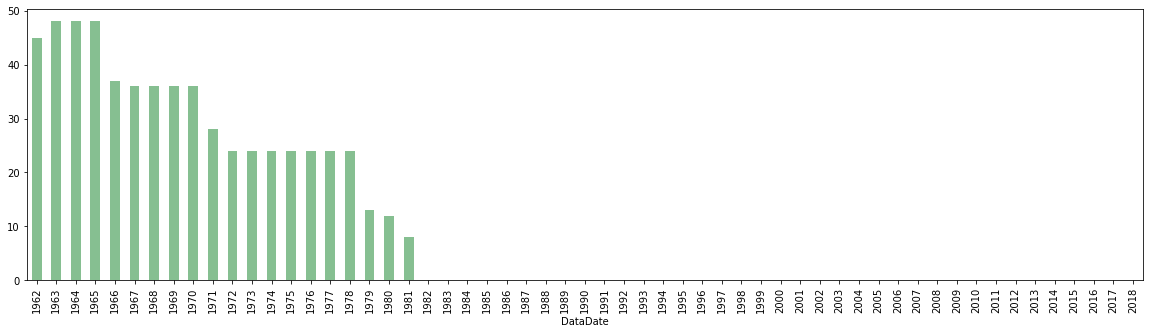

In [6]:
ax = Assets_table.groupby(pd.Grouper(freq = 'Y',
                            level = Assets_table.index.name))['NAN'].sum().plot(kind='bar', color='#86bf91', 
                            zorder=2, figsize = (20,5)) 
plt.xticks(np.arange(len(Assets_table.index.strftime('%Y').drop_duplicates())), 
           Assets_table.index.strftime('%Y').drop_duplicates(), rotation=90)
plt.show()

In [7]:
Assets_table = Assets_table.loc[Assets_table.index[350]: , :]
Assets_table.fillna(method='ffill', inplace=True)
Assets_table.fillna(method='bfill', inplace=True)
Assets_table.isnull().sum().sum()
Assets_table = Assets_table.drop(['NAN'], axis=1)
Assets_table = Assets_table.div(100, axis=0)

## Пример движения стоимости ряда компаний из генеральной совокупности 

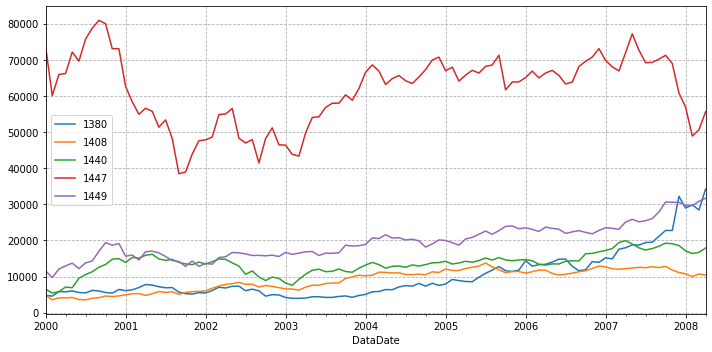

## Граница эффективности

Моделирование совокупности инвестиционных портфелей графически представляется в форме «пули», верхняя линия которой является эффективной границей. Точки, лежащие на ней, представляют собой портфели с наименьшим уровнем риска для заданной доходности. Остальные точки, находящиеся правее соответсвуют большему риску при том же показатели ожидаемой доходности

Построение эффективной границы предполагает нахождение двух крайних точек (минимального риска и максимальной доходности с учетом показателя риска). Для этого используем Scipy's optimize function как альтернативу перебору всех возможных вариантов сформированных портфелей. Scipy's optimize function сходна с функцией 'Поиск решения' в Excel, выполняет те же функции, при указании того, что нужно оптимизировать и какие при этом есть ограничения (constraints) и границы (bounds).

Ниже приведены функции для получения портфеля с наибольшим коэффициентом Шарпа. Данный показатель отражает во сколько раз уровень доходности выше уровня риска. Он указывает на стабильность прибыли, при этом отображая и ее количественную характеристику.

Поскольку в Scipy's optimize function отсутствует «максимизация» в качестве целевой функции должно быть выбрано то, что следует минимизировать. Поэтому "neg_sharpe_ratio" вычисляет отрицательный коэффициент Шарпа.

В функции "max_sharpe_ratio" сначала определяются аргументы (они не должны включать, те значения, которые будут изменяться в ходе оптимизации, в частности доли акций -"weights")

Поскольку доли акций в портфеле суммарно не должны превышать 1 (нельзя превысить бюджет более чем на 100 %) то: constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1}) Данное ограничение говорит о том, что сумма x должна быть равна 1.

Для лучшего понимания можно рассматривать данное условие как перенос 1 в левую сторону равенства: 'np.sum(x) == 1' has become 'np.sum(x)-1'

Границы задают другое ограничения для долей акции – они должны лежать в интервале от 0 до 1. Ведь нельзя задать отрицательное распределение ровно, как и превысить 100% показатель.

In [8]:
# Рассчитываем ожидаемый ретерн и матрицу ковариации доходностей
mean_returns = Assets_table.mean() # ожидаемый ретерн считаем, исходя из анализа фундаментальных и тех показателей, пока mean
cov_matrix = Assets_table.cov()
num_portfolios = 20000 # Кол-во расчитываемых портфелей (итераций)
risk_free_rate = 0.00 # Безрисковая процентная ставка, пока ставим 0
num_periods_annually = 12 # Количество месяцев в году

In [9]:
a_rsk = np.std(Assets_table) * np.sqrt(num_periods_annually)
a_ret = mean_returns*num_periods_annually

-------------------------------------------------------------------------------------------------------------------------
#### Функция вычисления риска по конкретному портфелю 

In [10]:
def PAP(weights, mean_returns, cov_matrix):
    #portfolio_annualised_performance
    returns = np.sum(mean_returns*weights ) * num_periods_annually
    std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) * np.sqrt(num_periods_annually)
    return std, returns

-------------------------------------------------------------------------------------------------------------------------
#### Функция максимизация коэффициента шарпа

In [11]:
def max_sharpe_ratio(mean_returns, cov_matrix, risk_free_rate):
    
    def neg_sharpe_ratio(weights, mean_returns, cov_matrix, risk_free_rate):
        p_var, p_ret = PAP(weights, mean_returns, cov_matrix)
        return -(p_ret - risk_free_rate) / p_var

    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix, risk_free_rate)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bound = (0.0,1.0)
    bounds = tuple(bound for asset in range(num_assets))
    
    result = sco.minimize(neg_sharpe_ratio, num_assets*[1./num_assets,], args=args,
                        method='SLSQP', bounds=bounds, constraints=constraints)
    return result

-------------------------------------------------------------------------------------------------------------------------
#### Функция максимизация доходности портфеля

In [12]:
def max_return(mean_returns, cov_matrix):
    
    def neg_portfolio_return(weights, mean_returns, cov_matrix):
        return -1*PAP(weights, mean_returns, cov_matrix)[1]
    
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bound = (0.0,1.0)
    bounds = tuple(bound for asset in range(num_assets))

    result = sco.minimize(neg_portfolio_return, num_assets*[1./num_assets,], args=args,
                          method='SLSQP', bounds=bounds, constraints=constraints)

    return result

-------------------------------------------------------------------------------------------------------------------------
#### Функция минимизации риска портфеля

In [13]:
def portfolio_volatility(weights, mean_returns, cov_matrix):
    return PAP(weights, mean_returns, cov_matrix)[0]

def min_variance(mean_returns, cov_matrix):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bound = (0.0,1.0)
    bounds = tuple(bound for asset in range(num_assets))

    result = sco.minimize(portfolio_volatility, num_assets*[1./num_assets,], args=args,
                          method='SLSQP', bounds=bounds, constraints=constraints)

    return result

-------------------------------------------------------------------------------------------------------------------------
#### Функция поиска эффективной границы

Как уже упоминалось выше эффективная граница — это линия, которая отражает, где находятся эффективные портфели для заданного уровня риска. Ниже приведены функции для ее вычисления. 

Первая - "efficient_return" вычисляет самый эффективный портфель для заданной доходности. Т.е. мы устанавливаем таргет значение доходности, которой портфель должен достигать, и получаем для нее эффективное значение риска.

Вторая - "efficient_frontier" принимает диапазон таргет доходностей и вычисляет эффективный риск для каждой из них.

In [14]:
def efficient_return(mean_returns, cov_matrix, target):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix)

    def portfolio_return(weights):
        return PAP(weights, mean_returns, cov_matrix)[1]

    constraints = ({'type': 'eq', 'fun': lambda x: portfolio_return(x) - target},
                   {'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bounds = tuple((0,1) for asset in range(num_assets))
    result = sco.minimize(portfolio_volatility, num_assets*[1./num_assets,], args=args,
                          method='SLSQP', bounds=bounds, constraints=constraints)
    return result

def efficient_frontier(mean_returns, cov_matrix, returns_range):
    efficients = []
    for ret in returns_range:
        efficients.append(efficient_return(mean_returns, cov_matrix, ret))
    return efficients

-------------------------------------------------------------------------------------------------------------------------
#### Функция генерации рандомных портфелей

Построим портфель с максимальным коэффициентом Шарпа и минимальным риском, а также отразим все случайно сгенерированные портфели. При этом мы не выбираем оптимальные портфели из случайно сгенерированных, а вычисляем их, используя Scipy's 'minimize' function. Приведенная ниже функция также строит границу эффективности.

In [15]:
def random_portfolios(num_portfolios, mean_returns, cov_matrix, risk_free_rate):
    results = np.zeros((len(Assets_table.columns),num_portfolios))
    weights_record = []
    for i in range(num_portfolios):
        weights = np.random.random(len(Assets_table.columns))
        weights /= np.sum(weights)
        weights_record.append(weights)
        portfolio_std_dev, portfolio_return = PAP(weights, mean_returns, cov_matrix)
        results[0,i] = portfolio_std_dev
        results[1,i] = portfolio_return
        results[2,i] = (portfolio_return - risk_free_rate) / portfolio_std_dev
    return results, weights_record

Оптимизируем. Ищем портфель с максимальным коэффициентом шарпа (max_sharpe), минимальным риском (min_vol), максимальной доходностью.

Сохраняем доли акций в портфеле в переменные max_sharpe_allocation, min_vol_allocation, max_ret_allocation

In [16]:
%%time
max_sharpe_res = max_sharpe_ratio(mean_returns, cov_matrix, risk_free_rate)['x']
min_var_res = min_variance(mean_returns, cov_matrix)['x']
max_ret_res = max_return(mean_returns, cov_matrix)['x']

sharpe_std, sharpe_ret = PAP(max_sharpe_res, mean_returns, cov_matrix)
min_std, min_ret = PAP(min_var_res, mean_returns, cov_matrix)
max_std, max_ret = PAP(max_ret_res, mean_returns, cov_matrix)

Wall time: 63.8 ms


In [17]:
sharpe_std, sharpe_ret = PAP(max_sharpe_res, mean_returns, cov_matrix)
max_sharpe_allocation = pd.DataFrame(max_sharpe_res,index=Assets_table.columns,columns=['allocation'])
max_sharpe_allocation.allocation = [round(i*100,2)for i in max_sharpe_allocation.allocation]
max_sharpe_allocation = max_sharpe_allocation.T

min_std, min_ret = PAP(min_var_res, mean_returns, cov_matrix)
min_vol_allocation = pd.DataFrame(min_var_res,index=Assets_table.columns,columns=['allocation'])
min_vol_allocation.allocation = [round(i*100,2)for i in min_vol_allocation.allocation]
min_vol_allocation = min_vol_allocation.T

max_std, max_ret = PAP(max_ret_res, mean_returns, cov_matrix)
max_ret_allocation = pd.DataFrame(max_ret_res,index=Assets_table.columns,columns=['allocation'])
max_ret_allocation.allocation = [round(i*100,2)for i in max_ret_allocation.allocation]
max_ret_allocation = max_ret_allocation.T

Находим (оптимизируем) эффективную границу портфелей

In [18]:
%%time
target = np.linspace(min_ret, max_ret, 20)
efficient_portfolios = efficient_frontier(mean_returns, cov_matrix, target)

Wall time: 496 ms


Преобразуем оптимизированные параметры для нормального отображения при использовании print

Генерируем (метод Монте Карло) num_portfolios случайных портфелей для отрисовки их на графике

In [19]:
%%time
results, _ = random_portfolios(num_portfolios,mean_returns, cov_matrix, risk_free_rate)

Wall time: 7.64 s


Wall time: 210 ms


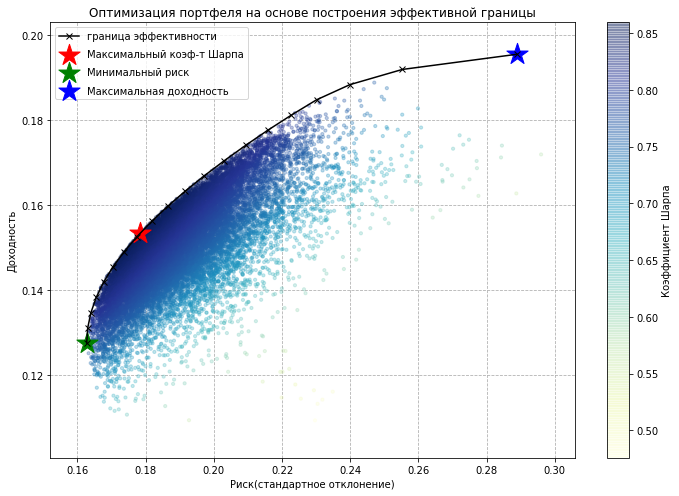

In [20]:
%%time

plt.figure(figsize=(10, 7))
plt.scatter(results[0,:],results[1,:],c=results[2,:],cmap='YlGnBu', marker='o', s=10, alpha=0.3)
plt.colorbar(label='Коэффициент Шарпа')
plt.scatter(sharpe_std,sharpe_ret,marker='*',color='r',s=500, label='Максимальный коэф-т Шарпа')
plt.scatter(min_std,min_ret,marker='*',color='g',s=500, label='Минимальный риск')
plt.scatter(max_std,max_ret,marker='*',color='b',s=500, label='Максимальная доходность')


plt.plot([p['fun'] for p in efficient_portfolios], target, 'k-x', label='граница эффективности')
plt.title('Оптимизация портфеля на основе построения эффективной границы')
plt.xlabel('Риск(стандартное отклонение)')
plt.ylabel('Доходность')
plt.grid(True, linestyle='--')
plt.legend(labelspacing=0.8)

plt.tight_layout();

--------------------------------------------------------------------------------
Распределение долей акций в портфеле с максимальным коэффициентом Шарпа:

Годовая доходность: 0.153
Годовой риск: 0.178
Коэффициент Шарпа 0.86


GVKey       2884   8455   13341  4885   5581 
allocation  11.81  27.95  30.59  14.33  15.31
--------------------------------------------------------------------------------
Распределение долей акций в портфеле с наименьшим показателем риска:

Годовая доходность: 0.127
Годовой риск: 0.163
Коэффициент Шарпа: 0.784


GVKey       2884   8455   13341  4885   5581 
allocation  25.24  46.69   10.7   8.65   8.72
--------------------------------------------------------------------------------
Распределение долей акций в портфеле с наименьшим показателем риска:

Годовая доходность: 0.195
Годовой риск: 0.289
Коэффициент Шарпа: 0.676


GVKey       2884   8455   13341  4885   5581 
allocation    0.0    0.0  100.0    0.0    0.0


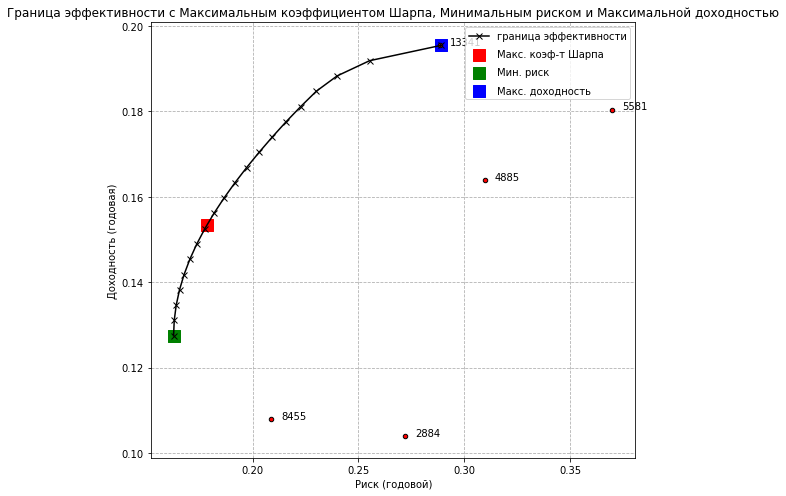

In [21]:
print("-"*80)
print("Распределение долей акций в портфеле с максимальным коэффициентом Шарпа:\n")
print("Годовая доходность:", round(sharpe_ret,3))
print("Годовой риск:", round(sharpe_std,3))
print("Коэффициент Шарпа", round((sharpe_ret - risk_free_rate)/sharpe_std, 3))
print("\n")
print(max_sharpe_allocation)

print("-"*80)
print("Распределение долей акций в портфеле с наименьшим показателем риска:\n")
print("Годовая доходность:", round(min_ret,3))
print("Годовой риск:", round(min_std,3))
print("Коэффициент Шарпа:", round((min_ret - risk_free_rate)/min_std, 3))
print("\n")
print(min_vol_allocation)

print("-"*80)
print("Распределение долей акций в портфеле с наименьшим показателем риска:\n")
print("Годовая доходность:", round(max_ret,3))
print("Годовой риск:", round(max_std,3))
print("Коэффициент Шарпа:", round((max_ret - risk_free_rate)/max_std, 3))
print("\n")
print(max_ret_allocation)

plt.figure(figsize=(10, 7))

#plt.scatter(results[0,:],results[1,:],c=results[2,:],cmap='YlGnBu', marker='o', s=10, alpha=0.3)

plt.scatter(sharpe_std, sharpe_ret, marker='s', color='r', s=150, label='Макс. коэф-т Шарпа')
plt.scatter(min_std, min_ret, marker='s', color='g', s=150, label='Мин. риск')
plt.scatter(max_std, max_ret, marker='s', color='b', s=150, label='Макс. доходность')

plt.scatter(a_rsk, a_ret, marker='o', s=20, c='red', edgecolors='black')
for i, txt in enumerate(Assets_table.columns):
    plt.annotate(txt, (np.array(a_rsk)[i], np.array(a_ret)[i]), xytext=(10,0), textcoords='offset points')

plt.plot([p['fun'] for p in efficient_portfolios], target, 'k-x', label='граница эффективности')

plt.grid(True, linestyle='--')
plt.title('Граница эффективности с Максимальным коэффициентом Шарпа, Минимальным риском и Максимальной доходностью')
plt.xlabel('Риск (годовой)')
plt.ylabel('Доходность (годовая)')
plt.legend(labelspacing=0.8)

#plt.xlim(0.1, 0.5)
#plt.ylim(-0.05, 0.25)

plt.tight_layout();

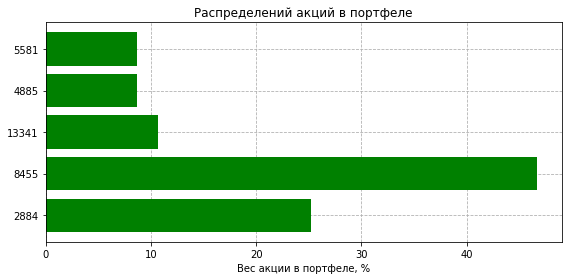

In [22]:
#max_sharpe_res
#min_var_res
#max_ret_res

ind = np.arange(Assets_table.columns.size)

plt.figure(figsize=(8,4))

#plt.barh(ind, max_ret_res, align='center')
#plt.barh(ind, max_sharpe_res, align='center')
plt.barh(ind, min_var_res, align='center', color = 'green')

plt.yticks(ind, Assets_table.columns)
plt.xlabel('Вес акции в портфеле, %')
plt.title('Распределений акций в портфеле')
#plt.legend(('Max Sharpe Ratio', 'Minimum Volatility'))
plt.grid(b=True, linestyle='--')

plt.tight_layout();

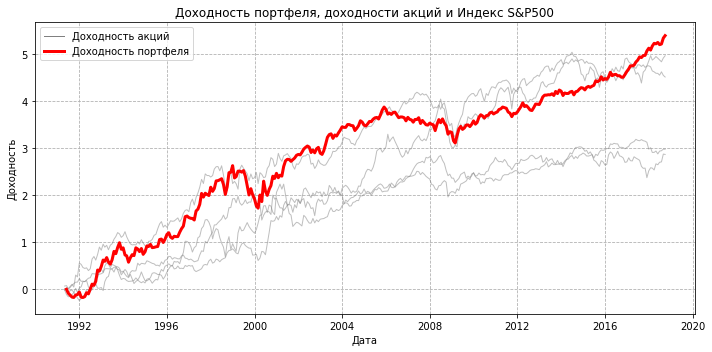

In [23]:
# Построение графика всех акций и доходности конкретного портфеля
#portfolio_alloc = max_sharpe_res
#portfolio_alloc = min_var_res
portfolio_alloc = max_ret_res

index = Assets_table.index
p_returns = pd.DataFrame(columns=['returns'])
for month in range(1, Assets_table.index.size):
    # Calculating portfolio return
    a_return = Assets_table.loc[index[month]]
    p_returns.loc[index[month]] = np.sum(a_return*(portfolio_alloc/100))

plt.figure(figsize=(10,5))

gray_line = mlines.Line2D([], [], color='gray', linewidth=1, label='Доходность акций')
plt.plot(Assets_table.cumsum(),'gray', linewidth=1, alpha=0.5)

red_line = mlines.Line2D([], [], color='red', linewidth=3, label='Доходность портфеля')
plt.plot(p_returns.cumsum(), 'red', linewidth=3)

#blue_line = mlines.Line2D([], [], color='blue', linewidth=3, label='Индекс S&P500')
#plt.plot(imoex.pct_change().cumsum(), 'blue', linewidth=3)

plt.grid(True, linestyle='--')
plt.title('Доходность портфеля, доходности акций и Индекс S&P500')
plt.xlabel('Дата')
plt.ylabel('Доходность')
plt.legend(handles=[gray_line, red_line]) # , blue_line
plt.tight_layout();


In [24]:
p = (-max_sharpe_ratio(mean_returns, cov_matrix, risk_free_rate)['fun'] * 100)/6
print('Cредняя годовая доходность портфеля:', str(round(p, 2))+'%')

#im = (imoex.pct_change().cumsum()[-1] * 100)/6
#print('Cредняя годовая доходность индекса Московской Биржи:', str(round(im, 2))+'%')

#print('Cредняя годовая доходность портфеля / индекс Московской Биржи:', round(p/im, 2))

Cредняя годовая доходность портфеля: 14.33%


## Построение Динамичной Границы Эффективности
https://quantdare.com/dynamic-markowitz-efficient-frontier/

Модель Марковица – один из самых известных методов портфельной теории, обеспечивает вычисление эффективных портфелей посредством математического программирования. Набор портфелей составляет эффективную границу. Стратегия основана на квадратичной оптимизации, поэтому минимизирует оценочный риск и отрицательную доходность. Эффективная граница вычислялась с использованием фиксированного временного окна, основанного на исторических данных. Реальный рынок не использует большие окна данных для расчета портфеля средней дисперсии. Поэтому интересно проанализировать эволюцию границы на основе временной шкалы. Здесь включены результаты динамической границы в статическом представлении с использованием Six Month Rolling Method

#### Six Month Rolling Method
Данный метод состоит из последовательного просмотра серии данных, в частности эффективных границ. В качестве ширина окна выбран полугодовой интервал (126 дней).

In [29]:
# Окно (месяца)
rolling = 6

#смещение во времени для каждой границы
offset = 1

risk_free_rate = 0.0 # Безрисковая процентная ставка
num_periods_annually = rolling # коэффициент для преобразования периодичности в годовой период

Формируем словарь в котором будем хранить по годам эффективные границы в виде списка

In [25]:
dm_risk = {}
dm_return = {}
for year in index.year.unique():
    dm_risk[year] = []
    dm_return[year] = []

In [26]:
print(dm_risk)
print(dm_return)

{1991: [], 1992: [], 1993: [], 1994: [], 1995: [], 1996: [], 1997: [], 1998: [], 1999: [], 2000: [], 2001: [], 2002: [], 2003: [], 2004: [], 2005: [], 2006: [], 2007: [], 2008: [], 2009: [], 2010: [], 2011: [], 2012: [], 2013: [], 2014: [], 2015: [], 2016: [], 2017: [], 2018: []}
{1991: [], 1992: [], 1993: [], 1994: [], 1995: [], 1996: [], 1997: [], 1998: [], 1999: [], 2000: [], 2001: [], 2002: [], 2003: [], 2004: [], 2005: [], 2006: [], 2007: [], 2008: [], 2009: [], 2010: [], 2011: [], 2012: [], 2013: [], 2014: [], 2015: [], 2016: [], 2017: [], 2018: []}


In [30]:
# списки для отрисовки 3D графика
sr_risk = []
sr_return = []

index = Assets_table.index

for day in tqdm_notebook(range(rolling, Assets_table.index.size, offset)):
    # Вырезаем часть таблицы размером rolling
    date0 = index[month]
    date1 = index[month-rolling+1]
    p = Assets_table.loc[date1:date0]
    
    # далее тот же код по оптимизации, что и выше. Но только теперь мы передоаем в него части таблицы цен
    mean_returns = Assets_table.mean()
    cov_matrix = Assets_table.cov()
    
    risk_min = min_variance(mean_returns, cov_matrix)
    return_max = max_return(mean_returns, cov_matrix)
    
    min_std, min_ret = PAP(risk_min['x'], mean_returns, cov_matrix)
    max_std, max_ret = PAP(return_max['x'], mean_returns, cov_matrix)
    
    target = np.linspace(min_ret, max_ret, 20)
    efficient_portfolios = efficient_frontier(mean_returns, cov_matrix, target)
    
    # Вытаскиваем из результатов оптимизации эффективную границу и сохраняем ее в словарь
    dm_risk[index[month].year].append([p['fun'] for p in efficient_portfolios])
    dm_return[index[month].year].append(target)
    
    # списки для отрисовки 3D графика
    sr_risk.append([p['fun'] for p in efficient_portfolios])
    sr_return.append(target)

In [31]:
c = ['gray', 'blue', 'green', 'peru', 'black', 'red']
l = []
t = 0
plt.figure(figsize=(10,5))
for year in index.year.unique():
    l.append(mlines.Line2D([], [], color=c[t], linewidth=4, label=index.year.unique()[t]))
    for i in range(len(dm_risk[year])):
        plt.plot(dm_risk[year][i], dm_return[year][i], c=c[t])
    t = t + 1

plt.grid(True, linestyle='--')
plt.title('Эффективные границы')
plt.xlabel('Риск')
plt.ylabel('Доходность')
plt.legend(handles=l)
plt.tight_layout();

IndexError: list index out of range

<Figure size 720x360 with 0 Axes>

Когда мы рассматриваем фиксированный период, не накапливая наблюдения, риск и доходность портфелей движутся иначе. В 2015 году риск увеличивается по сравнению с другими годами. В частности, это более 100%, тогда как в 2017 и 2018 годах он падает ниже 30%. Таким образом, динамическая эффективная граница может является наглядным примером эффекта добавления новых наблюдений с фиксированной начальной датой или в скользящий период.

Поиск стабильного региона
https://www.mathworks.com/company/newsletters/articles/developing-portfolio-optimization-models.html

Эффективные границы подвержены изменениям: некогда эффективный портфель может перестать быть доминирующим. Данный вопрос быть решен изучением временной эволюции эффективных границ и определением таких последовательностей портфелей, которые остаются относительно стабильными от одного рубежа к другому. Мы можем использовать Python для визуализации этой стабильной области.

In [ ]:
from plotly.offline import init_notebook_mode
#для вывода plotly-графиков в ноутбуке
init_notebook_mode(connected=True)

In [ ]:
y = np.array(sr_risk)
z = np.array(sr_return)

In [ ]:
a = np.linspace(2013, 2019, y.shape[0])
x = np.repeat(a[None], y.shape[1], axis=0).T

In [ ]:

data = [
    go.Surface(
        x=x,
        y=y,
        z=z
    )
]

In [ ]:
layout = go.Layout(
    title='Эффективные границы',
    width=800,
    height=700,
    scene=dict(
        xaxis=dict(
            title='Дата',
            gridcolor='rgb(255, 255, 255)',
            zerolinecolor='rgb(255, 255, 255)',
            showbackground=True,
            backgroundcolor='rgb(230, 230,230)'
        ),
        yaxis=dict(
            title='Риск',
            gridcolor='rgb(255, 255, 255)',
            zerolinecolor='rgb(255, 255, 255)',
            showbackground=True,
            backgroundcolor='rgb(230, 230,230)'
        ),
        zaxis=dict(title='Доходность',
                   gridcolor='rgb(255, 255, 255)',
                   zerolinecolor='rgb(255, 255, 255)',
                   showbackground=True,
                   backgroundcolor='rgb(230, 230,230)'
                  )
    )
)

In [ ]:
fig = go.Figure(data=data, layout=layout)
plotly.offline.iplot(fig)


Приведенный рисунок отражает эффективные границы на графике как функцию времени. Python рассчитал эффективные границы с 40 портфелями на каждой границы с интервалом в один месяц и построил график результатов. Данный рисунок позволяет выделить стабильный регион (темно-голубая область) – последовательность портфелей с небольшим отклонением доходности или риска и с неизменно положительной ожидаемой доходностью по отношению к рынку.